### PMIP4 analysis and producing figures for EOS 440 final project 

#### Intake data and filter activity, experiment, variable

In [1]:
# imports should run with given env

import intake
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path
import pandas as pd
import numpy as np
import xesmf as xe
from cftime import Datetime360Day, DatetimeProlepticGregorian, DatetimeNoLeap

In [2]:
# import esm data from server

import intake_esm
url ="https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"

In [3]:
# intake data as xarray

cat = intake.open_esm_datastore(url)

### Seperate out CMIP piControl experiment and the PMIP experiments.

In [4]:
cat_cmip = cat.search(activity_id = 'CMIP')
cat_picontrol = cat_cmip.search(experiment_id = 'piControl', variable_id = ['pr', 'ts'], institution_id = 'IPSL')

In [5]:
# check institutions to select the same instituation as the interglacial experiments for continuity purposes

cat_cmip.df['institution_id'].unique()

array(['MOHC', 'NOAA-GFDL', 'E3SM-Project', 'CNRM-CERFACS', 'IPSL',
       'NASA-GISS', 'BCC', 'MIROC', 'AWI', 'EC-Earth-Consortium', 'NCAR',
       'MRI', 'SNU', 'CAS', 'CCCma', 'INM', 'NUIST', 'HAMMOZ-Consortium',
       'CAMS', 'MPI-M', 'UA', 'NIMS-KMA', 'NCC', 'FIO-QLNM', 'KIOST',
       'CSIRO-ARCCSS', 'CSIRO', 'CCCR-IITM', 'THU', 'AS-RCEC', 'CMCC'],
      dtype=object)

In [6]:
# filter to PMIP and show experiments 

cat_pmip = cat.search(activity_id = 'PMIP')
cat_pmip.df['experiment_id'].unique()

array(['midHolocene', 'lig127k', 'lgm', 'past1000'], dtype=object)

In [7]:
# seperate each experiment 

cat_holo = cat_pmip.search(experiment_id = 'midHolocene', variable_id = ['pr', 'ts'])
cat_lig = cat_pmip.search(experiment_id = 'lig127k', variable_id = ['pr', 'ts'])


In [8]:
# check the ensemble member numbers for each dataset in order to understand limitations of comparison

print(cat_holo.df['member_id'].unique())
print(cat_lig.df['member_id'].unique())
print(cat_picontrol.df['member_id'].unique())

['r1i1p1f3' 'r1i1p1f2' 'r1i1p1f1']
['r1i1p1f1']
['r1i2p1f1' 'r1i1p1f1']


*Based on the above, we have limited ensemble members for comparison, and need to keep this in mind when discussing results*

#### Convert to dictionary dataset to begin plotting

In [9]:
dset_picont = cat_picontrol.to_dataset_dict(
    xarray_open_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True},
    skip_on_error=True
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [10]:
# check which keys it actually loads (skip - on - error)
#dset_picont.keys()

In [11]:
dset_holo = cat_holo.to_dataset_dict(
    xarray_open_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True}
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [12]:
dset_lig = cat_lig.to_dataset_dict(
    xarray_open_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True}
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [13]:
# option to un-comment (one at a time) and inspect parameters:

#dset_holo
#dset_lig
#dset_picont


In [14]:
# extracting dataset to be usable
# IPSL experiments are chosen for coninutity

ds_holo1 = dset_holo['PMIP.IPSL.IPSL-CM6A-LR.midHolocene.Amon.gr']
ds_lig1 = dset_lig['PMIP.IPSL.IPSL-CM6A-LR.lig127k.Amon.gr']
ds_now1 = dset_picont['CMIP.IPSL.IPSL-CM5A2-INCA.piControl.Amon.gr']


### Check if regridding is needed to compare plots

In [15]:
print(ds_holo1['lat'].shape, ds_now1['lat'].shape)
print(ds_holo1['lon'].shape, ds_now1['lon'].shape)

# yes!
# regrid all datasets to have the same as the lowest resolution
# in this case it is the piControl dataset

(143,) (96,)
(144,) (96,)


In [16]:
# regridding
ds_output = xr.Dataset(
    {
        'lat': (['lat'], ds_now1.lat.to_numpy(), {'units': 'degrees_north'}),
        'lon': (['lon'], ds_now1.lon.to_numpy(), {'units': 'degrees_east'}),
    }
)
#ds_output

In [17]:
regridder1 = xe.Regridder(ds_holo1, ds_output, "conservative")

/Users/kellybaker/anaconda3/envs/envir_440/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/Users/kellybaker/anaconda3/envs/envir_440/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


In [18]:
ds_holo = regridder1(ds_holo1, keep_attrs=True)
ds_lig = regridder1(ds_lig1, keep_attrs=True)


In [19]:
print(ds_holo['lat'].shape, ds_now1['lat'].shape)
print(ds_lig['lon'].shape, ds_now1['lon'].shape)

# check sizes

(96,) (96,)
(96,) (96,)


In [20]:
# rename to match following code

ds_now = ds_now1

# Precipitation Plots

## Preprocessing

In [21]:
# function to convert precipitation variable into mm/h

def convert_kg_m2s_to_mm_h(pr_kg_m2s):
    """
    Convert precipitation from kg/m²/s to mm/h.
    
    Parameters:
    pr_kg_m2s (xarray.DataArray or numpy array): precipitation in kg/m²/s
    
    Returns:
    xarray.DataArray or numpy array: Precipitation in mm/h
    """
    return pr_kg_m2s * 3600

In [22]:
# resample each dataset to be in seasons instead of per month for precip as is better to visualise monsoons.
# 'spr' meaning seasonal pr

spr_holo = ds_holo.pr.resample(time='QS-DEC').mean(dim='time') # extract pr variable 
spr_lig = ds_lig.pr.resample(time='QS-DEC').mean(dim='time')
spr_now = ds_now.pr.resample(time='QS-DEC').mean(dim='time')


## Global season-time-averaged precipitation figures 

In [23]:
def calc_precipitation(dataset, month):

    """
    Calculate the mean precipitation for a specific season across all years.
    NOTE: the data must already be grouped by season, where seasons are labelled as the first month of said season
    E.g. '6' for summer - will not work with 'DJF' season codes.

    Parameters:
    -----------
    dataset : xarray.Dataset
        Input dataset containing precipitation data with dimensions including 
        'dcpp_init_year', 'member_id', and 'time'.
    month : int
        The SEASON to average over and plot (12 = winter, ..., 6 = summer).

    Returns:
    --------
    xarray.DataArray
        Mean precipitation for the specified season, converted to mm/h.
    """
    
    # ignore ensemble and init year for now
    data = dataset.isel(dcpp_init_year=0).mean(dim='member_id')
    
    # extract indices where time is the desired season, based on first month index of season (12 = winter, 3 = spring etc)
    indices = [i for i, t in enumerate(data.time.values) if t.month == month]
    
    # select only desired season timstep
    data = data.isel(time=indices)
    
    # average over this season
    mean = data.mean(dim='time')
    
    # convert to mm/h using earlier function
    ga_mmh = convert_kg_m2s_to_mm_h(mean)

    return ga_mmh

# call function
calc_precip_holo =  calc_precipitation(spr_holo, 6)
calc_precip_lig = calc_precipitation(spr_lig, 6)
calc_precip_now = calc_precipitation(spr_now, 6)

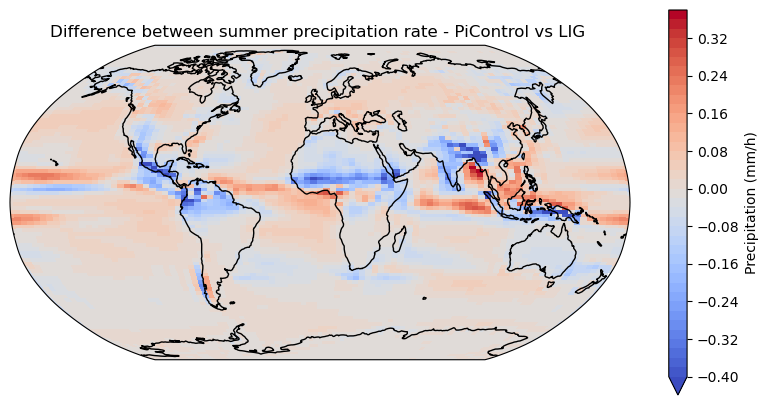

In [24]:
# plot the differences between the LIG and PICONT datasets 

diff_model_pic_lig = calc_precip_now  - calc_precip_lig

plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.Robinson())

# label is forced due to one anomalous cell - consistant throughout precipitation variables
diff_model_pic_lig.plot.pcolormesh(ax=ax, cmap='coolwarm', transform=ccrs.PlateCarree(), 
                                   levels=np.arange(-0.4, 0.4, 0.02), cbar_kwargs={'label': 'Precipitation (mm/h)'})
ax.coastlines()
ax.set_title("Difference between summer precipitation rate - PiControl vs LIG ")

plt.show()

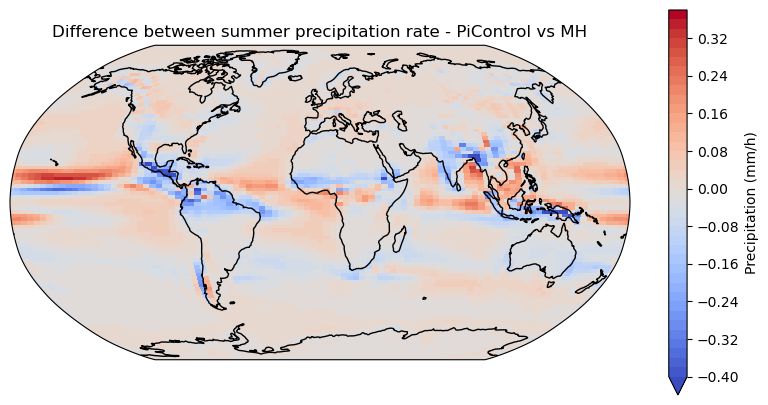

In [25]:
# plot the differences between the MH and PICONT datasets 

diff_model_pic_mh = calc_precip_now  - calc_precip_holo


plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.Robinson())

diff_model_pic_mh.plot.pcolormesh(ax=ax, cmap='coolwarm', transform=ccrs.PlateCarree(), levels=np.arange(-0.4, 0.4, 0.02), cbar_kwargs={'label': 'Precipitation (mm/h)'})

ax.coastlines()
ax.set_title("Difference between summer precipitation rate - PiControl vs MH")

plt.show()

In [26]:
# similar function to above - just including plotting code too, to repeat for standard spatial precip plots
# again, label must be forced for these datasets

def plot_precipitation_season(dataset, title, month, start_year=-600, levels=np.arange(0, 1, 0.036)):
    """
    Plot average precipitation for a specified season across a given period.
    NOTE: the data must already be grouped by season, where seasons are labelled as the first month of said season
    E.g. '6' for summer - will not work with 'DJF' season codes.

    Parameters:
    -----------
    dataset : xarray.Dataset
        Input dataset containing precipitation data with dimensions including 
        'dcpp_init_year', 'member_id', and 'time'.
    title : str
        Title for the plot.
    month : int
        The SEASON to average over and plot (12 = winter, ..., 6 = summer).
    start_year : int, optional
        Index of the starting year for plotting (default is -600).
    levels : array-like, optional
        Contour levels for the precipitation plot (default is np.arange(0, 1, 0.036) for these datasets.).

    Returns:
    --------
    None
        Displays a global map of mean precipitation for the specified seasonal average in mm/h.
    """
    
    # ignore ensemble and init year for now
    # specify start year (only production run) as an index
    data = dataset.isel(time=slice(start_year, None), dcpp_init_year=0).mean(dim='member_id')

    
    # extract indices where time is the desired season, based on first month index of season (12 = winter, 3 = spring etc)
    indices = [i for i, t in enumerate(data.time.values) if t.month == month]
    
    # select only desired season timstep
    data = data.isel(time=indices)
    
    # average over this season
    mean = data.mean(dim='time')
    
    # convert to mm/h using earlier function
    ga_mmh = convert_kg_m2s_to_mm_h(mean)

    # plot!
    plt.figure(figsize=(12, 7))
    ax = plt.axes(projection=ccrs.Robinson())

    ga_mmh.plot.pcolormesh(ax=ax, cmap='coolwarm', transform=ccrs.PlateCarree(), levels=levels, cbar_kwargs={'label': 'Precipitation (mm/h)'})

    ax.coastlines()
    ax.set_title(f"{title}")

    plt.show()

In [27]:
# can inspect other months

#plot_precipitation_season(spr_holo, "Production Run of Precipitation in the Mid Holocene, Winter", 12)

In [28]:
#plot_precipitation_season(spr_holo, "Production Run of Precipitation in the Mid Holocene, Spring", 3)

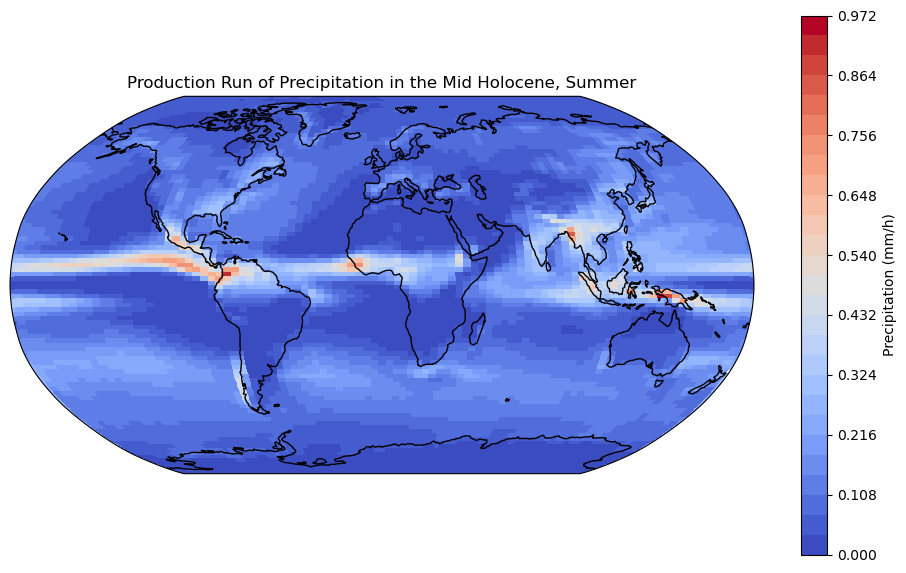

In [29]:
plot_precipitation_season(spr_holo, "Production Run of Precipitation in the Mid Holocene, Summer", 6)

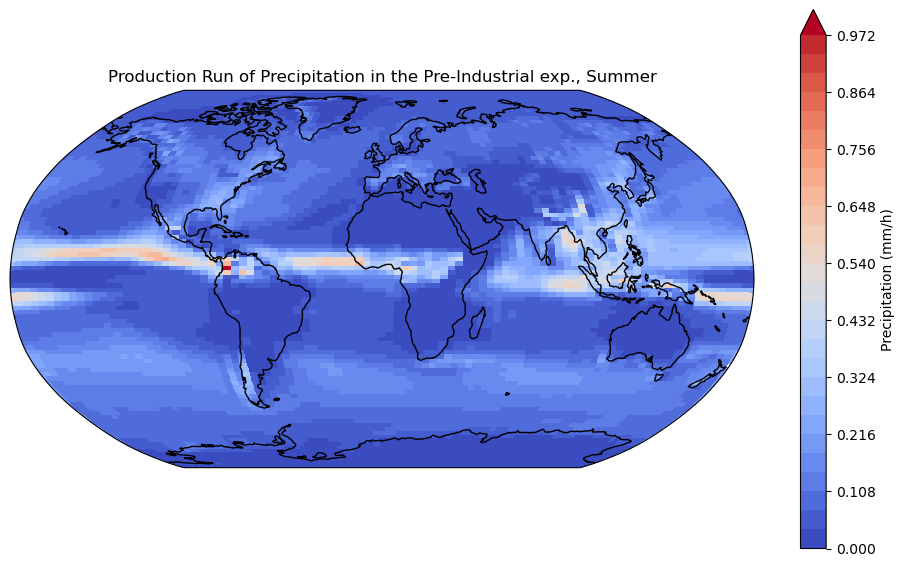

In [30]:
plot_precipitation_season(spr_now, "Production Run of Precipitation in the Pre-Industrial exp., Summer", 6)

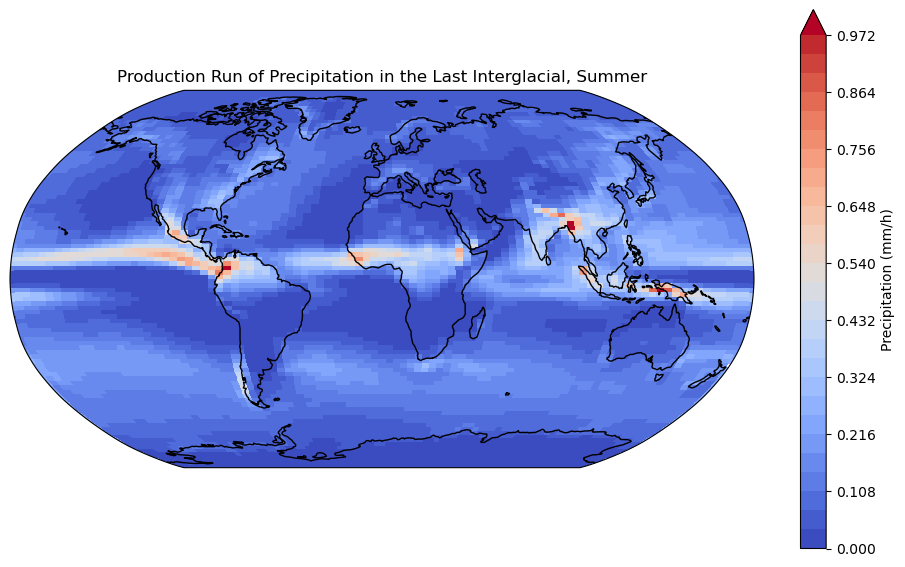

In [31]:
plot_precipitation_season(spr_lig, "Production Run of Precipitation in the Last Interglacial, Summer", 6)

### SUPPLEMENTARY: Spatial visualisation of standard deviation of the precipitation

In [32]:
def plot_precipitation_season_std(dataset, title, month, start_year=-600, levels=np.arange(0, 0.5, 0.02)):
    """
    Plot the standard deviation of seasonal precipitation (in mm/h) over the given period.

    Parameters:
    - dataset: xarray dataset with 'pr' (precipitation) variable, seasonal time steps (12 = winter, 6=summer...)
    - title: title for the plot
    - month: desired month to plot 
    - start_year: index to start the production run (default is -600)
    - levels: contour levels for plotting (to avoid outliers)

    Returns:
    --------
    None
        Displays a global map of standard deviation of precipitation for the specified seasonal average in mm/h.
    
    """

    # subset to production run and mean over ensemble members
    data = dataset.isel(time=slice(start_year, None), dcpp_init_year=0).mean(dim='member_id')

    # select only seasonal timesteps 
    season_indices = [i for i, t in enumerate(data.time.values) if t.month == month]
    data = data.isel(time=season_indices)

    # compute standard deviation over time (i.e., across all seasons of this type)
    std = data.std(dim='time')

    # convert to mm/h
    ga_mmh_std = convert_kg_m2s_to_mm_h(std)

    # plot!
    plt.figure(figsize=(12, 7))
    ax = plt.axes(projection=ccrs.Robinson())

    ga_mmh_std.plot.pcolormesh(
        ax=ax,
        cmap='magma_r',
        transform=ccrs.PlateCarree(),
        levels=levels,
        cbar_kwargs={'label': 'Seasonal Precip Std Dev (mm/h)'}
    )

    ax.coastlines()
    ax.set_title(f"{title} — Std Dev of Seasonal Precipitation")
    plt.show()


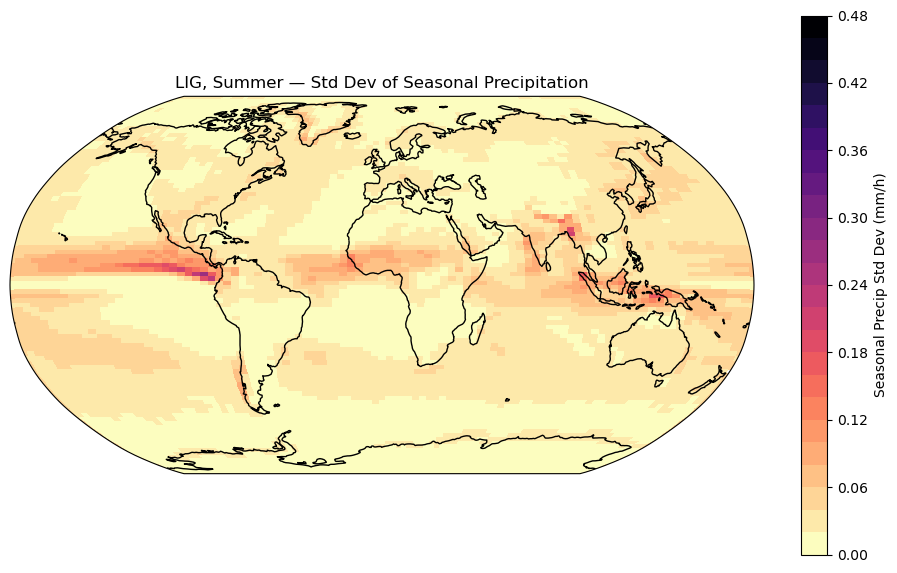

In [33]:
plot_precipitation_season_std(spr_lig, "LIG, Summer", 6)

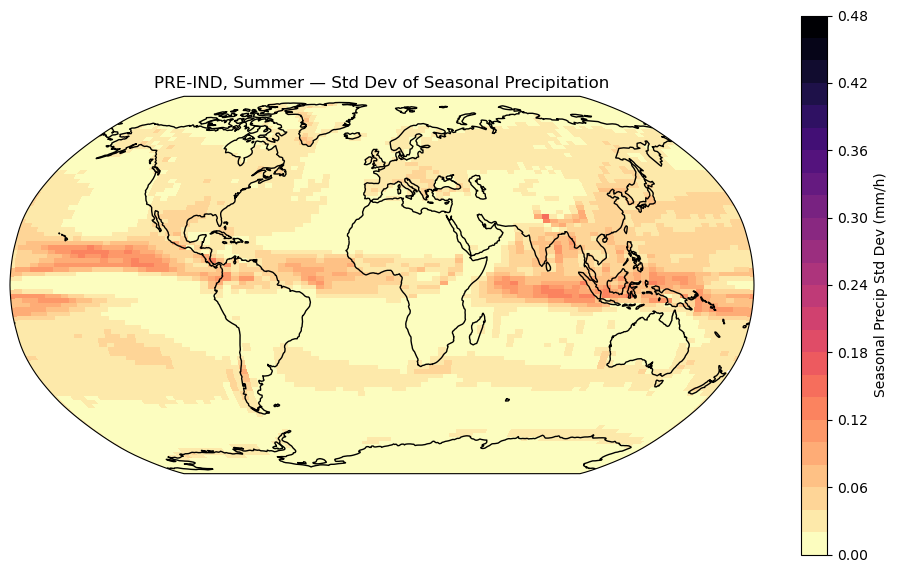

In [34]:
plot_precipitation_season_std(spr_now, "PRE-IND, Summer", 6)

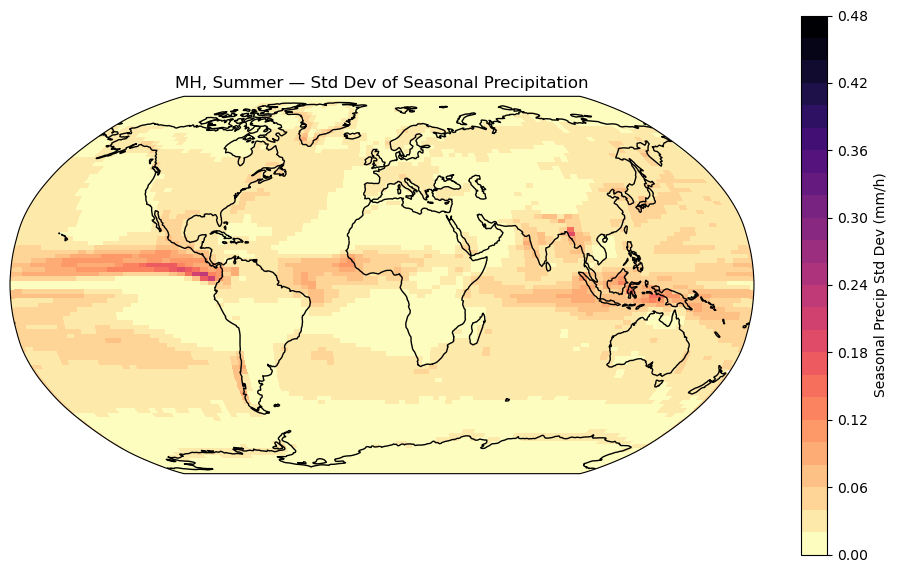

In [35]:
plot_precipitation_season_std(spr_holo, "MH, Summer", 6)

In [36]:
# definition for computing timseries of precipitation

def time_series_global_precip(dataset, start_year):
    """
    Compute timeseries for precipitation over a given period.

    Parameters:
    - dataset: xarray dataset with 'pr' (precipitation) variable
    - start_year: however many desired cycles to plot (index)

    Returns:
    --------
    ga_mmh: xarray.DataArray
        timseries to be passed into plotting code.
    
    """
    
    last50 = dataset.isel(time=slice(start_year, None), dcpp_init_year=0).mean(dim='member_id')
    
    global_avg = last50.mean(dim=['lat', 'lon'])
    
    ga_mmh = convert_kg_m2s_to_mm_h(global_avg)
    
    return ga_mmh

In [37]:
holo_ts_seasonal = time_series_global_precip(spr_holo, -40)
holo_ts_monthly = time_series_global_precip(ds_holo.pr, -120)


In [38]:
now_1 = time_series_global_precip(spr_now, -40)


### SUPPLEMENTARY: Sanity check - plots visualising how well seasonal averages capture the total precipitation pattern

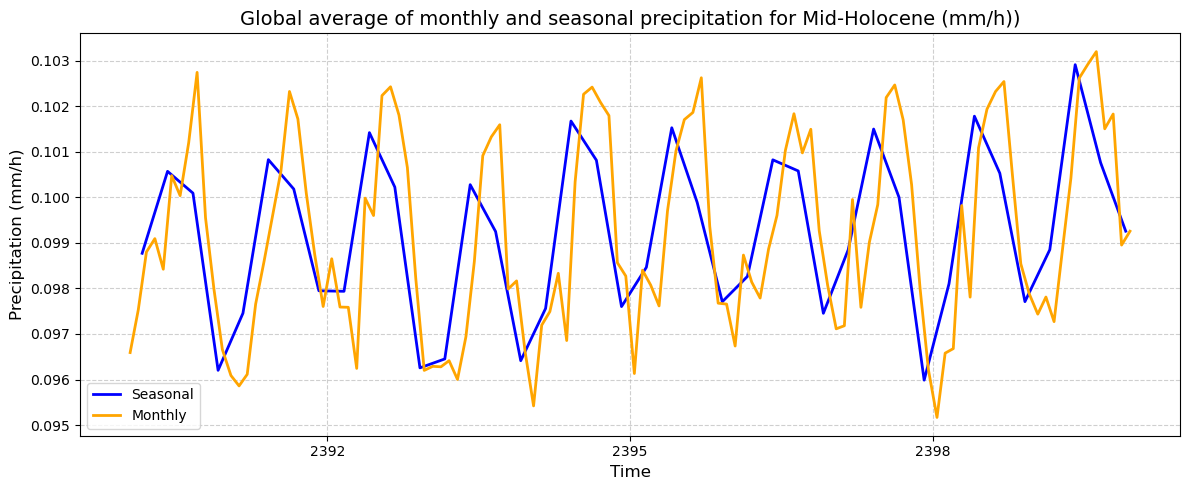

In [39]:
# definition to just plot two graphs together on one axis

def dual_plot_timeseries(ds1, ds2, title):
    """
    Plot a seasonal and monthly precipitation dataset on the same axis

    Parameters:
    - ds1: xarray dataset with 'pr' (precipitation) variable, seasonal
    - ds1: xarray dataset with 'pr' (precipitation) variable, monthly
    - title: plot title

    Returns:
    --------
    NONE
        plots the datasets.
    
    """
    
    fig, ax = plt.subplots(figsize=(12, 5))
    
    ds1.plot(ax=ax, color='blue', label='Seasonal', linewidth=2)
    ds2.plot(ax=ax, color='orange', label='Monthly', linewidth=2)
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Time", fontsize=12)
    ax.set_ylabel("Precipitation (mm/h)", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

dual_plot_timeseries(holo_ts_seasonal, holo_ts_monthly, "Global average of monthly and seasonal precipitation for Mid-Holocene (mm/h))")

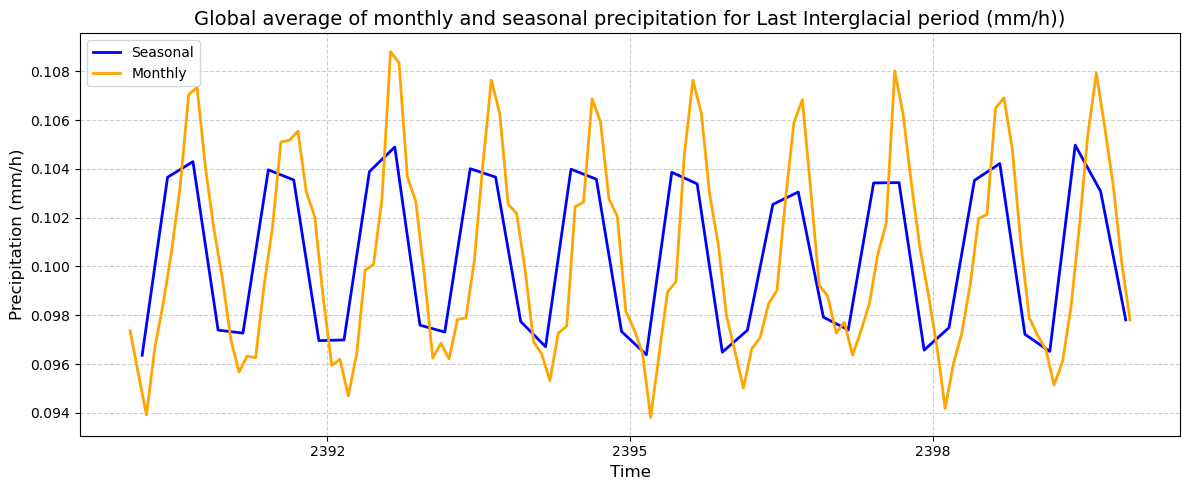

In [40]:
lig_ts_seasonal = time_series_global_precip(spr_lig, -40)
lig_ts_monthly = time_series_global_precip(ds_lig.pr, -120)
dual_plot_timeseries(lig_ts_seasonal, lig_ts_monthly, "Global average of monthly and seasonal precipitation for Last Interglacial period (mm/h))")


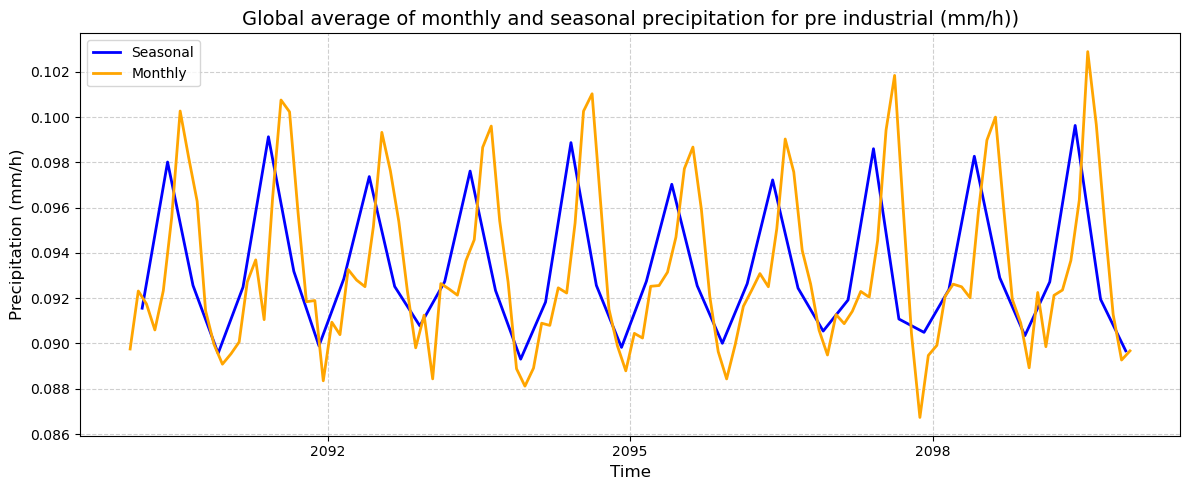

In [41]:
now_ts_seasonal = time_series_global_precip(spr_now, -40)
now_ts_monthly = time_series_global_precip(ds_now.pr, -120)
dual_plot_timeseries(now_ts_seasonal, now_ts_monthly, "Global average of monthly and seasonal precipitation for pre industrial (mm/h))")


### Plots for global average monthly precip patterns (comparison between models)

In [42]:
# create data slice by selecting precip + last 10 months + lat/lon mean

lig_glob = convert_kg_m2s_to_mm_h(ds_lig.pr.isel(time=slice(-120, None), dcpp_init_year=0).mean(dim=["lat", "lon", "member_id"]))
holo_glob = convert_kg_m2s_to_mm_h(ds_holo.pr.isel(time=slice(-120, None), dcpp_init_year=0).mean(dim=["lat", "lon", "member_id"]))
now_glob = convert_kg_m2s_to_mm_h(ds_now.pr.isel(time=slice(-120, None), dcpp_init_year=0).mean(dim=["lat", "lon", "member_id"]))


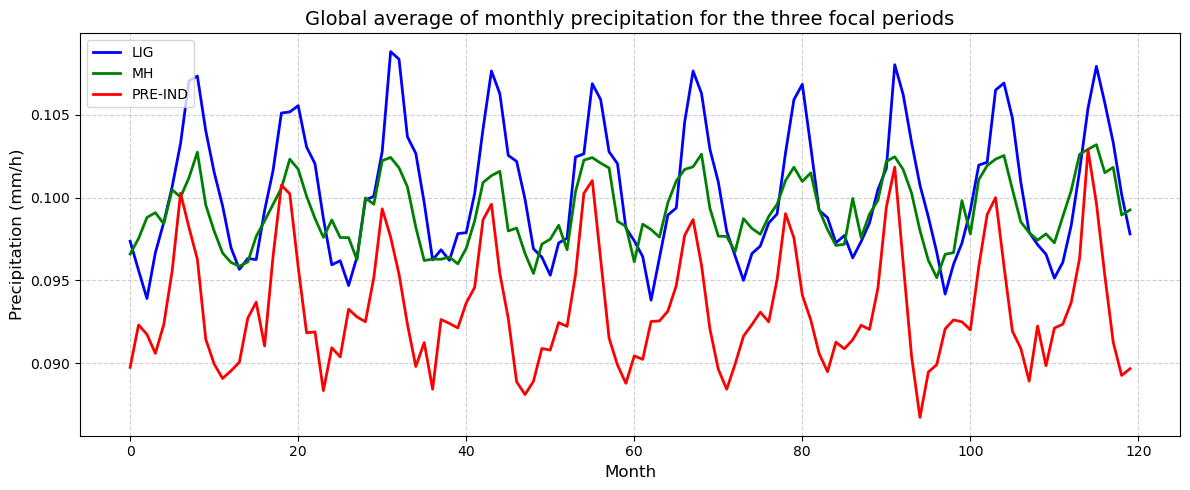

In [43]:
# instantiate a common time array for the two different actviities
common_time = np.arange(120)  # Months 0 to 119

# plot
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(common_time, lig_glob .values, color='blue', label='LIG', linewidth=2)
ax.plot(common_time, holo_glob.values, color='green', label='MH', linewidth=2)
ax.plot(common_time, now_glob.values, color='red', label='PRE-IND', linewidth=2)

ax.set_title("Global average of monthly precipitation for the three focal periods", fontsize=14)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Precipitation (mm/h)", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()

### SUPPLEMENTARY: plots for NH/SH average monthly precip patterns

In [44]:
# create data slice by selecting precip + last 10 months + lat slice + lat/long mean

lig_nh = convert_kg_m2s_to_mm_h(ds_lig.pr.isel(time=slice(-120, None), lat=slice(0, 90), dcpp_init_year=0).mean(dim=["lat", "lon", "member_id"]), )
holo_nh = convert_kg_m2s_to_mm_h(ds_holo.pr.isel(time=slice(-120, None), lat=slice(0, 90), dcpp_init_year=0).mean(dim=["lat", "lon", "member_id"]))
now_nh = convert_kg_m2s_to_mm_h(ds_now.pr.isel(time=slice(-120, None), lat=slice(0, 90), dcpp_init_year=0).mean(dim=["lat", "lon", "member_id"]))

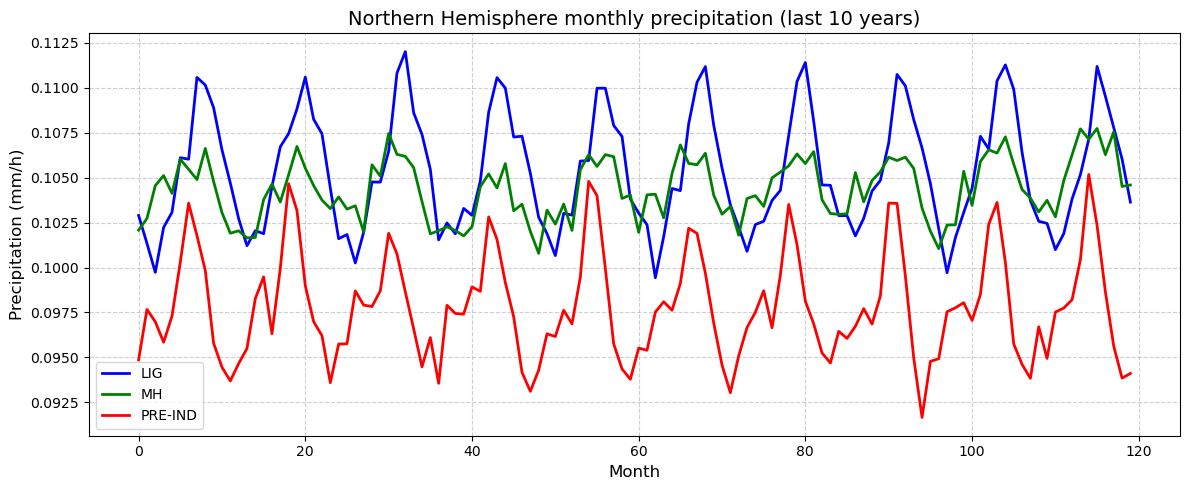

In [45]:
# instantiate a common time array for the two different actviities
common_time = np.arange(120)  # Months 0 to 119

# plot
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(common_time, lig_nh.values, color='blue', label='LIG', linewidth=2)
ax.plot(common_time, holo_nh.values, color='green', label='MH', linewidth=2)
ax.plot(common_time, now_nh.values, color='red', label='PRE-IND', linewidth=2)

ax.set_title( "Northern Hemisphere monthly precipitation (last 10 years)", fontsize=14)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Precipitation (mm/h)", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()


### Calculate numerical differences differences between models at wet/dry seasons

In [54]:
def describe_timeseries(ds, label):
    """
    Prints variable statistics, quantitive analysis of the timeseries plots.
    
    Parameters:
    - ds: xarray dataset with a single variable (pr, ts)
    - label: title of dataset passed
    
    Returns:
    --------
    NONE
    prints neat tables of statistical values for the given dataset.
    
    """
    ds_np = ds.values  # convert to NumPy array 
    
    # overall stats of the series
    mean_val = np.mean(ds_np)
    max_val = np.max(ds_np)
    min_val = np.min(ds_np)
    seas_diff = max_val - min_val
    
    # reshape to (10 years, 12 months) and to allow to compute std of yearly means
    ts_reshaped = ds_np.reshape(10, 12)
    annual_means = ts_reshaped.mean(axis=1)
    annual_std = np.std(annual_means)
    
    # print results
    print(f"--- {label} ---")
    print(f"Mean: {mean_val:.3f} mm/h")
    print(f"Max: {max_val:.3f} mm/h")
    print(f"Min: {min_val:.3f} mm/h")
    print(f"Seasonal Difference: {seas_diff:.3f} mm/h")
    print(f"Std Dev of Annual Means: {annual_std:.5f} mm/h\n")


In [55]:
# call function

describe_timeseries(lig_glob, "Last Interglacial (LIG)(NH)")
describe_timeseries(holo_glob, "Mid-Holocene (MH)(NH)")
describe_timeseries(now_glob, "Pre-Industrial (PRE-IND)(NH)")


--- Last Interglacial (LIG)(NH) ---
Mean: 0.100 mm/h
Max: 0.109 mm/h
Min: 0.094 mm/h
Seasonal Difference: 0.015 mm/h
Std Dev of Annual Means: 0.00022 mm/h

--- Mid-Holocene (MH)(NH) ---
Mean: 0.099 mm/h
Max: 0.103 mm/h
Min: 0.095 mm/h
Seasonal Difference: 0.008 mm/h
Std Dev of Annual Means: 0.00049 mm/h

--- Pre-Industrial (PRE-IND)(NH) ---
Mean: 0.093 mm/h
Max: 0.103 mm/h
Min: 0.087 mm/h
Seasonal Difference: 0.016 mm/h
Std Dev of Annual Means: 0.00023 mm/h



### SUPPLEMENTARY: Plotting averaged longitude, precipitation by latitude

In [56]:
# function to plot preicp at a given lat slice

def plot_precipitation_fixed_lon(dataset, title, month, start_year=-600):
    """
    Calculates precipitation averaged over time and longitude (to plot lat by precip in mm/h).

    Parameters:
    - dataset: xarray dataset with a single variable (pr, ts)
    - title: plot title
    - month: start month of given season (to time average over)

    Returns:
    --------
    np.array
        The precipitation values of the desribed averaging.
    
    """
    # ignore ensemble and init year for now
    # specify start year (only production run) as an index
    data = dataset.isel(time=slice(start_year, None), dcpp_init_year=0).mean(dim=['lon', 'member_id'])
    
    # Extract indices where time is the desired season, based on first month index of season (12 = winter, 3 = spring etc)
    indices = [i for i, t in enumerate(data.time.values) if t.month == month]
    
    # Select only desired season timstep
    data = data.isel(time=indices)
    
    # Average over this season
    mean = data.mean(dim='time')
    
    # Convert to mm/h using earlier function
    ga_mmh = convert_kg_m2s_to_mm_h(mean)
    return ga_mmh


In [57]:
# produce and plot said longitude-time averaged plots

a = plot_precipitation_fixed_lon(spr_holo, "test", 6,  start_year=-600)
b = plot_precipitation_fixed_lon(spr_lig, "test", 6, start_year=-600)
c = plot_precipitation_fixed_lon(spr_now, "test", 6, start_year=-600)

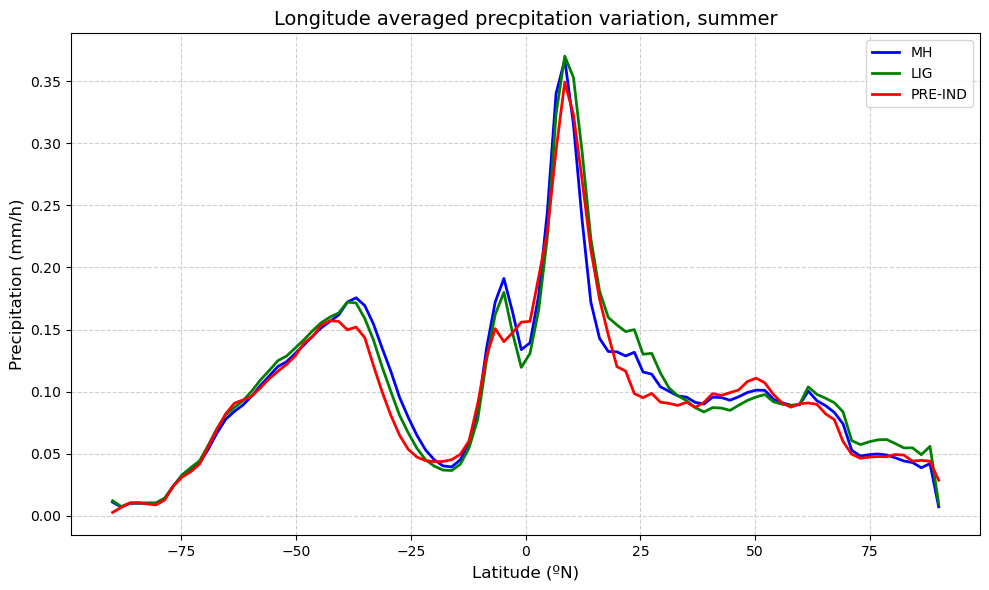

In [58]:

fig, ax = plt.subplots(figsize=(10, 6))
    
a.plot(ax=ax, color='blue', label='MH', linewidth=2)
b.plot(ax=ax, color='green', label='LIG', linewidth=2)
c.plot(ax=ax, color='red', label='PRE-IND', linewidth=2)
ax.set_title("Longitude averaged precpitation variation, summer", fontsize=14)
ax.set_xlabel("Latitude (ºN)", fontsize=12)
ax.set_ylabel("Precipitation (mm/h)", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()


### Plotting the yearly precip cycle with std. bars

In [59]:
# plot the seasonal cycle

def plot_seasonal_cycle_with_error(ds_lig, ds_holo, ds_now):
    """
    Takes the baseline dataset with one variable, processes it, calculates the mean and deviations,
    Plots mean with standard semi-transparent 2xdeviaiton bars .

    Parameters:
    -----------
    ds_lig: last interglacial dataset (xarray)
    ds_holo: mid holocene dataset (xarray)
    ds_now: picontrol dataset (xarray)

    Returns:
    --------
    NONE
        Plots the described above on one axis.
    """

    def preprocess(ds_pr):
        # convert to mm/h and reduce over lat/lon/member
        pr = convert_kg_m2s_to_mm_h(ds_pr.isel(time=slice(-120, None), dcpp_init_year=0).mean(dim=["lat", "lon", "member_id"]))
        
        # reshape to (10 years, 12 months)
        pr_reshaped = pr.values.reshape(10, 12)
        
        # mean and std across years for each month
        pr_monthly_mean = pr_reshaped.mean(axis=0)
        pr_monthly_std = 2 * pr_reshaped.std(axis=0)  # 2σ for error bars
        return pr_monthly_mean, pr_monthly_std

    # preprocess each dataset
    lig_mean, lig_std = preprocess(ds_lig)
    holo_mean, holo_std = preprocess(ds_holo)
    now_mean, now_std = preprocess(ds_now)

    # set time axis to 1 year
    months = np.arange(1, 13)

    # plot!
    fig, ax = plt.subplots(figsize=(12, 5))

    # LIG
    ax.plot(months, lig_mean, label='LIG', color='blue', linewidth=2)
    ax.fill_between(months, lig_mean - lig_std, lig_mean + lig_std, color='blue', alpha=0.3, label='LIG ±2σ')

    # MH
    ax.plot(months, holo_mean, label='MH', color='green', linewidth=2)
    ax.fill_between(months, holo_mean - holo_std, holo_mean + holo_std, color='green', alpha=0.3, label='MH ±2σ')

    # PRE-IND
    ax.plot(months, now_mean, label='PRE-IND', color='red', linewidth=2)
    ax.fill_between(months, now_mean - now_std, now_mean + now_std, color='red', alpha=0.3, label='PRE-IND ±2σ')


    ax.set_title("Global Monthly Mean Precipitation (10-year seasonal cycle)", fontsize=14)
    ax.set_xlabel("Month", fontsize=12)
    ax.set_ylabel("Precipitation (mm/h)", fontsize=12)
    ax.set_xticks(months)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    plt.tight_layout()
    plt.show()


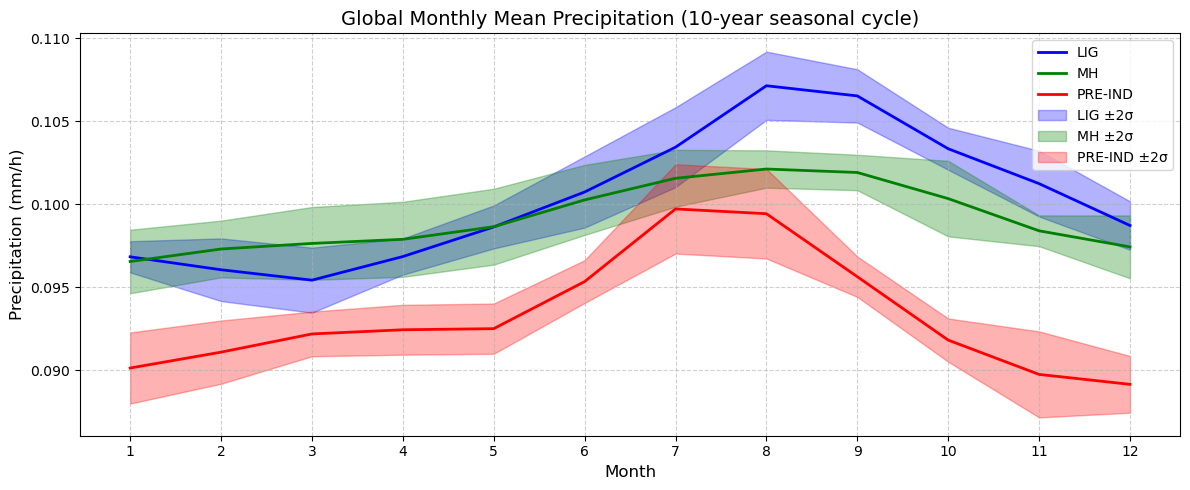

In [60]:
plot_seasonal_cycle_with_error(ds_lig.pr, ds_holo.pr, ds_now.pr)


# Temperature plots

### plot spatial representation of surface temperature, and the differences between

In [61]:
# seasonally resample datasets
sts_holo = ds_holo.ts.resample(time='QS-DEC').mean(dim='time') # extract pr variable 
sts_lig = ds_lig.ts.resample(time='QS-DEC').mean(dim='time')
sts_now = ds_now.ts.resample(time='QS-DEC').mean(dim='time')

In [ ]:
# definition to plot spatial temperature values (like precip)

def plot_temperature(dataset, title, month, levels=np.arange(200 , 340, 2), start_year=-600):
    """
    Plot average surface temperature for a specified season across a given period.
    NOTE: the data must already be grouped by season, where seasons are labelled as the first month of said season
    E.g. '6' for summer - will not work with 'DJF' season codes.

    Parameters:
    -----------
    dataset : xarray.Dataset
        Input dataset containing temp data with dimensions including 
        'dcpp_init_year', 'member_id', and 'time'.
    title : str
        Title for the plot.
    month : int
        The SEASON to average over and plot (12 = winter, ..., 6 = summer) as a month index.
    start_year : int, optional
        Index of the starting year for plotting (default is -600).

    Returns:
    --------
    xarray datarray
        Displays a global map of mean surface temperature for the specified seasonal average in K.
        returns the mean temperature dataset
    """
    data = dataset.isel(time=slice(start_year, None), dcpp_init_year=0).mean(dim='member_id')

    
    # extract indices where time is the desired season, based on first month index of season (12 = winter, 3 = spring etc)
    indices = [i for i, t in enumerate(data.time.values) if t.month == month]
    
    # select only desired season timstep
    data = data.isel(time=indices)
    
    # average over this season
    mean_temp = data.mean(dim='time')
    # plot!
    plt.figure(figsize=(12, 7))
    ax = plt.axes(projection=ccrs.Robinson())

    mean_temp.plot.pcolormesh(ax=ax, cmap='coolwarm', transform=ccrs.PlateCarree(), levels=np.arange(200 , 340, 2), cbar_kwargs={'label': 'Temperature (K)'})

    ax.coastlines()
    ax.set_title(f"{title}")

    plt.show()
    return mean_temp

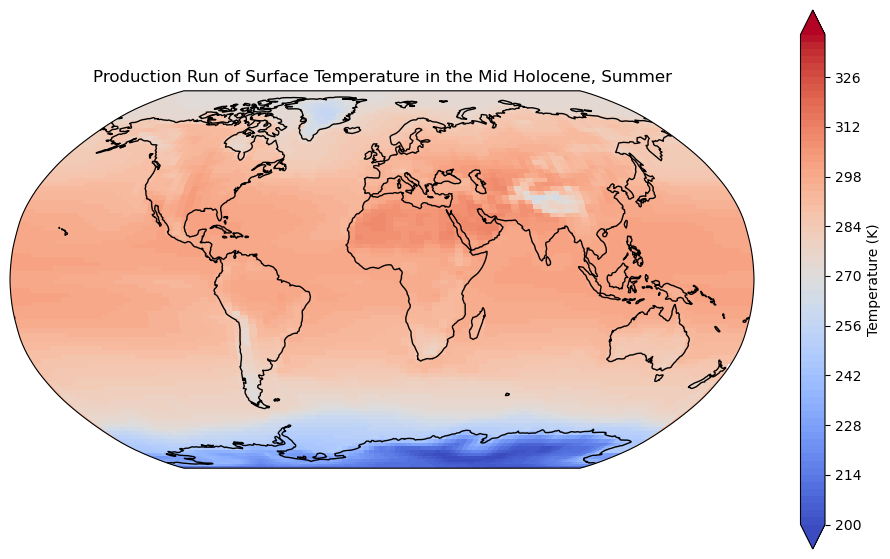

In [73]:
holo_temp_array = plot_temperature(sts_holo, "Production Run of Surface Temperature in the Mid Holocene, Summer", 6, start_year=-600)

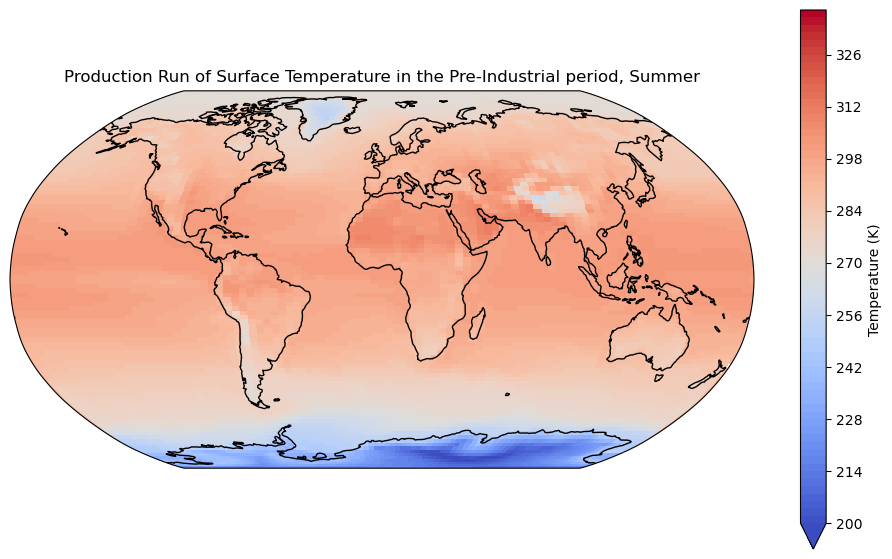

In [74]:
now_temp_array = plot_temperature(sts_now, "Production Run of Surface Temperature in the Pre-Industrial period, Summer", 6,  start_year=-600)

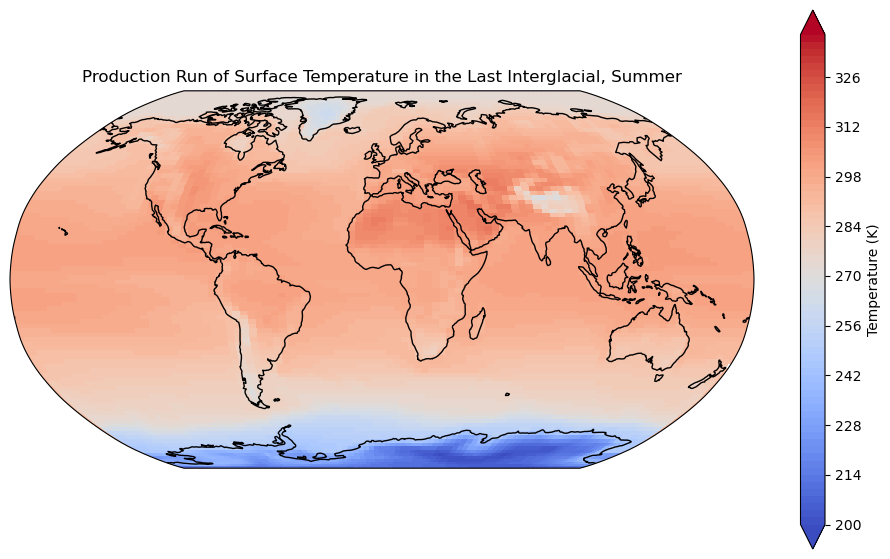

In [75]:
lig_temp_array = plot_temperature(sts_lig, "Production Run of Surface Temperature in the Last Interglacial, Summer", 6, start_year=-600)

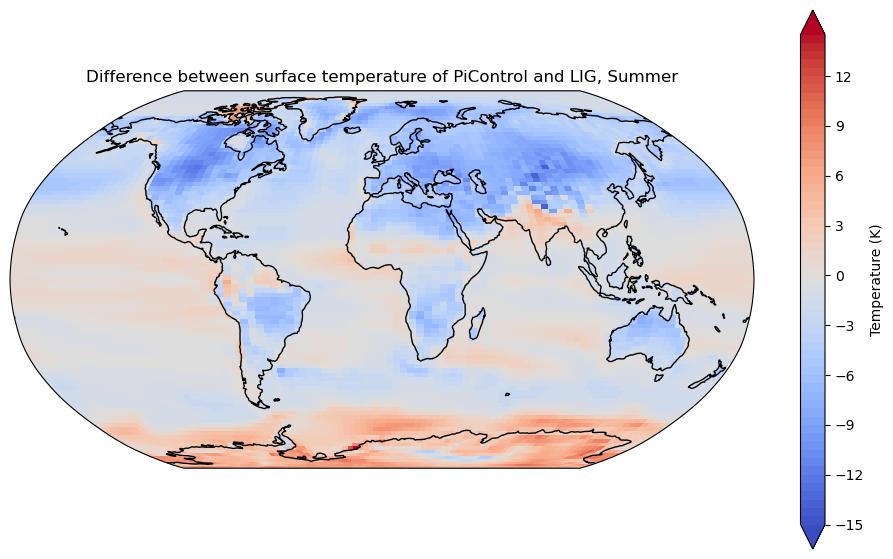

In [81]:
# plot the differences between the control and interglacial simualtions

plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.Robinson())

(now_temp_array - lig_temp_array).plot.pcolormesh(ax=ax, cmap='coolwarm', transform=ccrs.PlateCarree(), levels = np.arange(-15, 15, 0.5), cbar_kwargs={'label': 'Temperature (K)'})

ax.coastlines()
ax.set_title("Difference between surface temperature of PiControl and LIG, Summer")

plt.show()

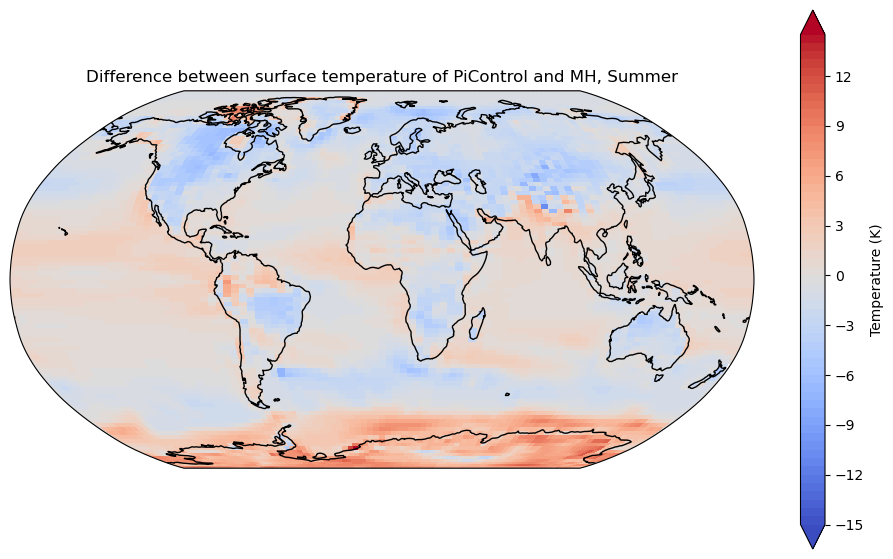

In [99]:

plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.Robinson())

(now_temp_array - holo_temp_array).plot.pcolormesh(ax=ax, cmap='coolwarm', transform=ccrs.PlateCarree(), levels = np.arange(-15, 15, 0.5), cbar_kwargs={'label': 'Temperature (K)'})

ax.coastlines()
ax.set_title("Difference between surface temperature of PiControl and MH, Summer")

plt.show()

### SUPPLEMENTARY -  Plot timeseries of temperature variations

In [83]:
# create data slice by selecting precip + last 10 months + lat/lon mean

lig_glob_ts = ds_lig.ts.isel(time=slice(-120, None), lat=slice(0, 90), dcpp_init_year=0).mean(dim=["lat", "lon", "member_id"])
holo_glob_ts = ds_holo.ts.isel(time=slice(-120, None), lat=slice(0, 90), dcpp_init_year=0).mean(dim=["lat", "lon", "member_id"])
now_glob_ts = ds_now.ts.isel(time=slice(-120, None), lat=slice(0, 90), dcpp_init_year=0).mean(dim=["lat", "lon", "member_id"])


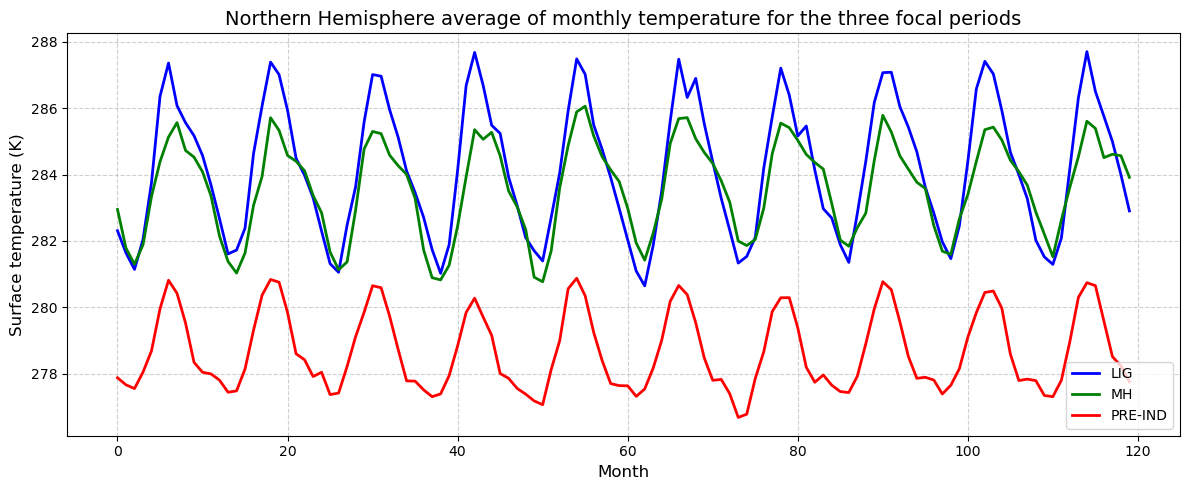

In [84]:
# instantiate a common time array for the two different actviities
common_time = np.arange(120)  # Months 0 to 119

# plot
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(common_time, lig_glob_ts .values, color='blue', label='LIG', linewidth=2)
ax.plot(common_time, holo_glob_ts.values, color='green', label='MH', linewidth=2)
ax.plot(common_time, now_glob_ts.values, color='red', label='PRE-IND', linewidth=2)

ax.set_title("Northern Hemisphere average of monthly temperature for the three focal periods", fontsize=14)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Surface temperature (K)", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()

In [85]:
#plot_temperature((sts_holo - sts_lig), "Difference between surface temperature of MH and LIG, Summer", start_year=-600)

In [86]:
#def plot_temperature_dual(dataset1, dataset2, title, start_year=-600):
#    # ignore ensemble and init year for now
#    # specify start year (only production run) as an index
#    data1 = dataset1.isel(time=slice(start_year, None), dcpp_init_year=0).mean(dim='member_id').sel(lat=slice(-89, 89))
#    data2 = dataset2.isel(time=slice(start_year, None), dcpp_init_year=0).mean(dim='member_id').sel(lat=slice(-89, 89))
#    now_aligned = data1.assign_coords(time=data2.time)
#    
#    mean_temp1 = now_aligned.mean(dim='time')
#    mean_temp2 = data2.mean(dim='time')
#    # plot!
#    plt.figure(figsize=(12, 7))
#    ax = plt.axes(projection=ccrs.Robinson())
#
#    (mean_temp1-mean_temp2).plot.pcolormesh(ax=ax, cmap='coolwarm', transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'Temperature (K)'})
#
#    ax.coastlines()
#    ax.set_title(f"{title}")
#
#    plt.show()
#
#
#plot_temperature_dual(sts_now, sts_lig, "Difference between surface temperature of PiControl and LIG, Summer", start_year=-600)

In [87]:
#plot_temperature_dual(sts_now, sts_holo, "Difference between surface temperature of PiControl and MH, Summer", start_year=-600)

## SUPPLEMENTARY - Plot latitude temperature variation

In [88]:
def plot_temp_over_lats(dataset, month, start_year=-600):
    """
    Get dataset to plot longitude averaged surface temperature by latitude
    NOTE: the data must already be grouped by season, where seasons are labelled as the first month of said season
    E.g. '6' for summer - will not work with 'DJF' season codes.

    Parameters:
    -----------
    dataset : xarray.Dataset
        Input dataset containing temperature data with dimensions including 
        'dcpp_init_year', 'member_id', and 'time'.
    month : int
        The SEASON to average over and plot (12 = winter, ..., 6 = summer) as a month index.
    start_year : int, optional
        Index of the starting year for plotting (default is -600).

    Returns:
    --------
    xarray datarray
        latitude varying temperature array.
    """
    
    # filter by additional dimesions
    data = dataset.isel(time=slice(start_year, None), dcpp_init_year=0).mean(dim=['member_id', 'lon'])
    
    # filter time steps to the desired month 
    indices = [i for i, t in enumerate(data.time.values) if t.month == month]
    data = data.isel(time=indices)
    
    # average over time (seasonal mean)
    mean = data.mean(dim='time')
    
    # due to regridding issue
    mean_nh = mean.sel(lat=slice(-89, 89))

    return mean_nh
 

In [89]:
nh_mh = plot_temp_over_lats(sts_holo, 6,start_year=-600)
nh_lig = plot_temp_over_lats(sts_lig,  6, start_year=-600)
nh_now = plot_temp_over_lats(sts_now,  6, start_year=-600)

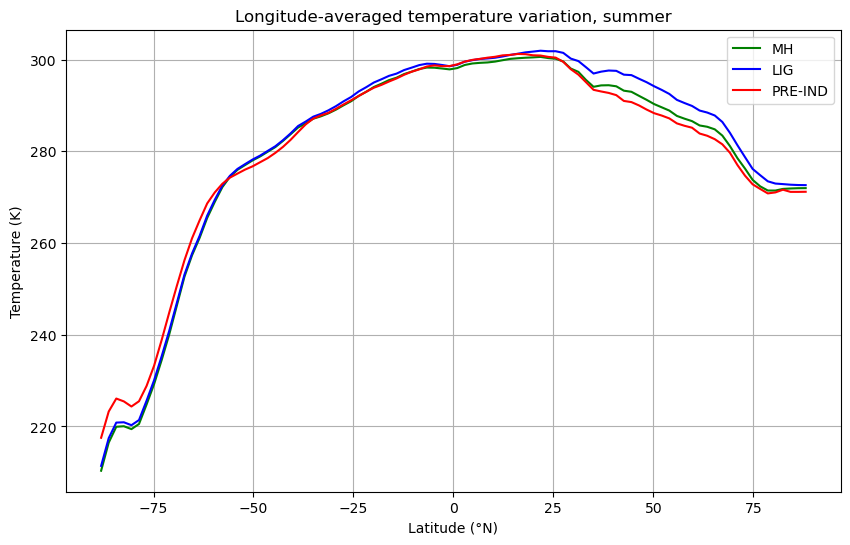

In [90]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(nh_mh.lat, nh_mh.values, color='green', label='MH' )
plt.plot(nh_lig.lat, nh_lig.values, color='blue', label='LIG')
plt.plot(nh_now.lat, nh_now.values, color='red', label='PRE-IND')
plt.xlabel("Latitude (°N)")
plt.ylabel("Temperature (K)")
plt.title("Longitude-averaged temperature variation, summer")
plt.legend()
plt.grid(True)
plt.show()


### Statistical info - temperature

In [100]:
# same as earlier, just for temperature
def describe_timeseries_temp(ds, label):
    """
    Prints variable statistics, quantitive analysis of the timeseries plots.
    
    Parameters:
    - ds: xarray dataset with a single variable (pr, ts)
    - label: title of dataset passed
    
    Returns:
    --------
    NONE
    prints neat tables of statistical values for the given dataset.
    
    """
    ds_np = ds.values  # convert to NumPy array 
    
    # overall stats of the series
    mean_val = np.mean(ds_np)
    max_val = np.max(ds_np)
    min_val = np.min(ds_np)
    seas_diff = max_val - min_val
    
    # reshape to (10 years, 12 months) and to allow to compute std of yearly means
    ts_reshaped = ds_np.reshape(10, 12)
    annual_means = ts_reshaped.mean(axis=1)
    annual_std = np.std(annual_means)
    
    # print results
    print(f"--- {label} ---")
    print(f"Mean: {mean_val:.3f} K")
    print(f"Max: {max_val:.3f} K")
    print(f"Min: {min_val:.3f} K")
    print(f"Seasonal Difference: {seas_diff:.3f} K")
    print(f"Std Dev of Annual Means: {annual_std:.5f} K\n")

In [92]:
describe_timeseries_temp(lig_glob_ts, 'Last Interglacial')

--- Last Interglacial ---
Mean: 284.179 K
Max: 287.708 K
Min: 280.644 K
Seasonal Difference: 7.064 K
Std Dev of Annual Means: 0.12309 K



In [93]:
describe_timeseries_temp(holo_glob_ts, 'Mid Holocene')

--- Mid Holocene ---
Mean: 283.606 K
Max: 286.063 K
Min: 280.768 K
Seasonal Difference: 5.294 K
Std Dev of Annual Means: 0.20840 K



In [94]:
describe_timeseries_temp(now_glob_ts, 'Pre-Industrial')

--- Pre-Industrial ---
Mean: 278.682 K
Max: 280.874 K
Min: 276.677 K
Seasonal Difference: 4.197 K
Std Dev of Annual Means: 0.14087 K



### Temperature timeseries with std error bars

In [97]:
# same definition as earlier, for temperature, tweaked.

def plot_seasonal_cycle_with_error(ds_lig, ds_holo, ds_now):
    """
    Takes the baseline dataset with one variable, processes it, calculates the mean and deviations,
    Plots mean with standard semi-transparent 2xdeviaiton bars .

    Parameters:
    -----------
    ds_lig: last interglacial dataset (xarray)
    ds_holo: mid holocene dataset (xarray)
    ds_now: picontrol dataset (xarray)

    Returns:
    --------
    NONE
        Plots the described above on one axis.
    """

    def preprocess(ds_pr):
        # Convert to mm/h and reduce over lat/lon/member
        pr = ds_pr.isel(time=slice(-120, None), dcpp_init_year=0).mean(dim=["lat", "lon", "member_id"])
        
        # Reshape to (10 years, 12 months)
        pr_reshaped = pr.values.reshape(10, 12)
        
        # Mean and std across years for each month
        pr_monthly_mean = pr_reshaped.mean(axis=0)
        pr_monthly_std = 2 * pr_reshaped.std(axis=0)  # 2σ for error bars
        return pr_monthly_mean, pr_monthly_std

    # Preprocess each dataset
    lig_mean, lig_std = preprocess(ds_lig)
    holo_mean, holo_std = preprocess(ds_holo)
    now_mean, now_std = preprocess(ds_now)

    # Time axis: months 1 to 12
    months = np.arange(1, 13)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 5))

    # LIG
    ax.plot(months, lig_mean, label='LIG', color='blue', linewidth=2)
    ax.fill_between(months, lig_mean - lig_std, lig_mean + lig_std, color='blue', alpha=0.3, label='LIG ±2σ')

    # MH
    ax.plot(months, holo_mean, label='MH', color='green', linewidth=2)
    ax.fill_between(months, holo_mean - holo_std, holo_mean + holo_std, color='green', alpha=0.3, label='MH ±2σ')

    # PRE-IND
    ax.plot(months, now_mean, label='PRE-IND', color='red', linewidth=2)
    ax.fill_between(months, now_mean - now_std, now_mean + now_std, color='red', alpha=0.3, label='PRE-IND ±2σ')

    # Formatting
    ax.set_title("Global Monthly Mean Surface Temperature (10-year seasonal cycle)", fontsize=14)
    ax.set_xlabel("Month", fontsize=12)
    ax.set_ylabel("Temperature (K)", fontsize=12)
    ax.set_xticks(months)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    plt.tight_layout()
    plt.show()


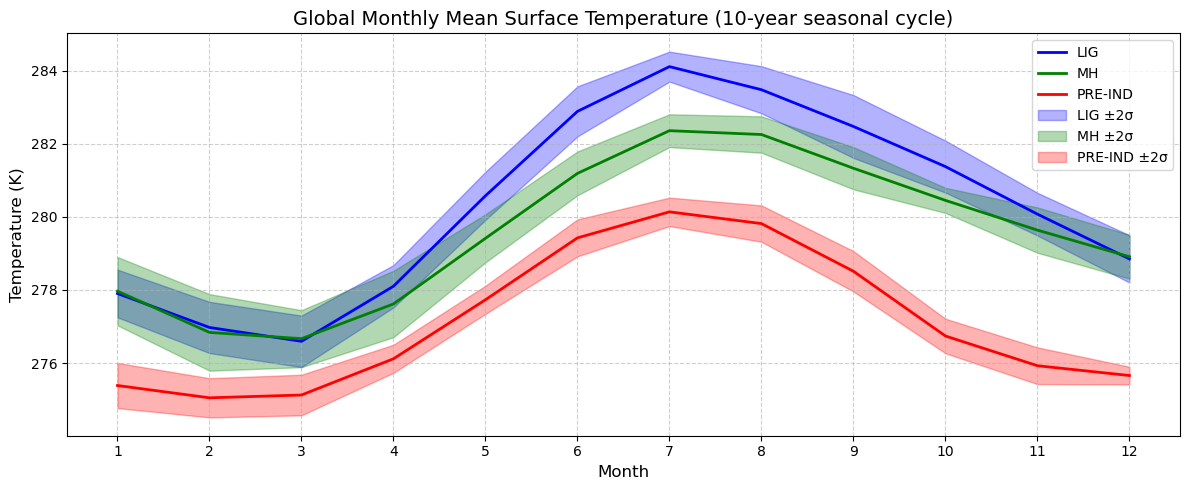

In [98]:
plot_seasonal_cycle_with_error(ds_lig.ts, ds_holo.ts, ds_now.ts)

# NOTES ON CODE:

There are a lot of repititions throughout the code - if i had more time, I would have condensed this greatly.

Any figures titled 'SUPPLEMENTARY' were for research and understanding purposes and are not features in the body of the write up.